# Step 1 — Imports and constants

In [1]:

!pip install -q xgboost joblib shap
# seaborn, scikit-learn, pandas, numpy, matplotlib are already on Colab usually


In [2]:

import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import joblib

from xgboost import XGBClassifier

# plotting style
sns.set(style='whitegrid')

# Column names for UCI Covertype dataset (no header in file)
NUMERIC_COLS = [
    'Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',
    'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points'
]
WILDERNESS_COLS = [f'Wilderness_Area{i}' for i in range(1,5)]
SOIL_COLS = [f'Soil_Type{i}' for i in range(1,41)]
COLUMN_NAMES = NUMERIC_COLS + WILDERNESS_COLS + SOIL_COLS + ['Cover_Type']

# Data URL (UCI)
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"

# Random seed and sample options
RND = 42
SAMPLE_N = None   # set to an int like 100000 if you want a faster smaller dataset for experimentation


# Step 2 — Download & load dataset

In [3]:
# Colab cell
print("Downloading and loading dataset...")
t0 = time.time()
df = pd.read_csv(DATA_URL, header=None, names=COLUMN_NAMES, compression='gzip')
print(f"Loaded {df.shape[0]} rows and {df.shape[1]} columns in {time.time()-t0:.1f}s")

if SAMPLE_N is not None:
    df = df.sample(SAMPLE_N, random_state=RND).reset_index(drop=True)
    print("Sampled down to", df.shape)


Loaded 581012 rows and 55 columns in 4.3s


# Step 3 — Quick inspection & cleaning

In [4]:

# Basic info
print("First rows:")
display(df.head())

print("\nData types and non-null counts:")
display(df.info())

# Missing values
print("\nMissing values (sum):", df.isnull().sum().sum())

# Class distribution
print("\nCover Type counts:")
display(df['Cover_Type'].value_counts().sort_index())

# Basic stats for numeric features
display(df[NUMERIC_COLS].describe().T)


First rows:


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5



Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2   

None


Missing values (sum): 0

Cover Type counts:


,count
Cover_Type,
1,211840
2,283301
3,35754
4,2747
5,9493
6,17367
7,20510


,count,mean,std,min,25%,50%,75%,max
Elevation,581012.0,2959.365301,279.984734,1859.0,2809.0,2996.0,3163.0,3858.0
Aspect,581012.0,155.656807,111.913721,0.0,58.0,127.0,260.0,360.0
Slope,581012.0,14.103704,7.488242,0.0,9.0,13.0,18.0,66.0
Horizontal_Distance_To_Hydrology,581012.0,269.428217,212.549356,0.0,108.0,218.0,384.0,1397.0
Vertical_Distance_To_Hydrology,581012.0,46.418855,58.295232,-173.0,7.0,30.0,69.0,601.0
Horizontal_Distance_To_Roadways,581012.0,2350.146611,1559.254870,0.0,1106.0,1997.0,3328.0,7117.0
Hillshade_9am,581012.0,212.146049,26.769889,0.0,198.0,218.0,231.0,254.0
Hillshade_Noon,581012.0,223.318716,19.768697,0.0,213.0,226.0,237.0,254.0
Hillshade_3pm,581012.0,142.528263,38.274529,0.0,119.0,143.0,168.0,254.0
Horizontal_Distance_To_Fire_Points,581012.0,1980.291226,1324.195210,0.0,1024.0,1710.0,2550.0,7173.0


# Step 4 — Basic visualizations (EDA)

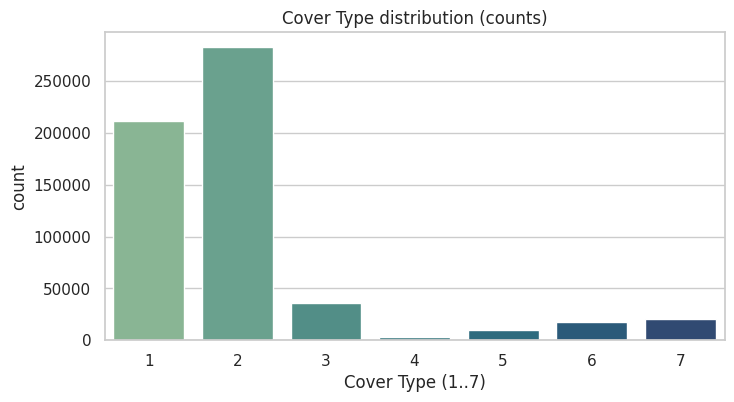

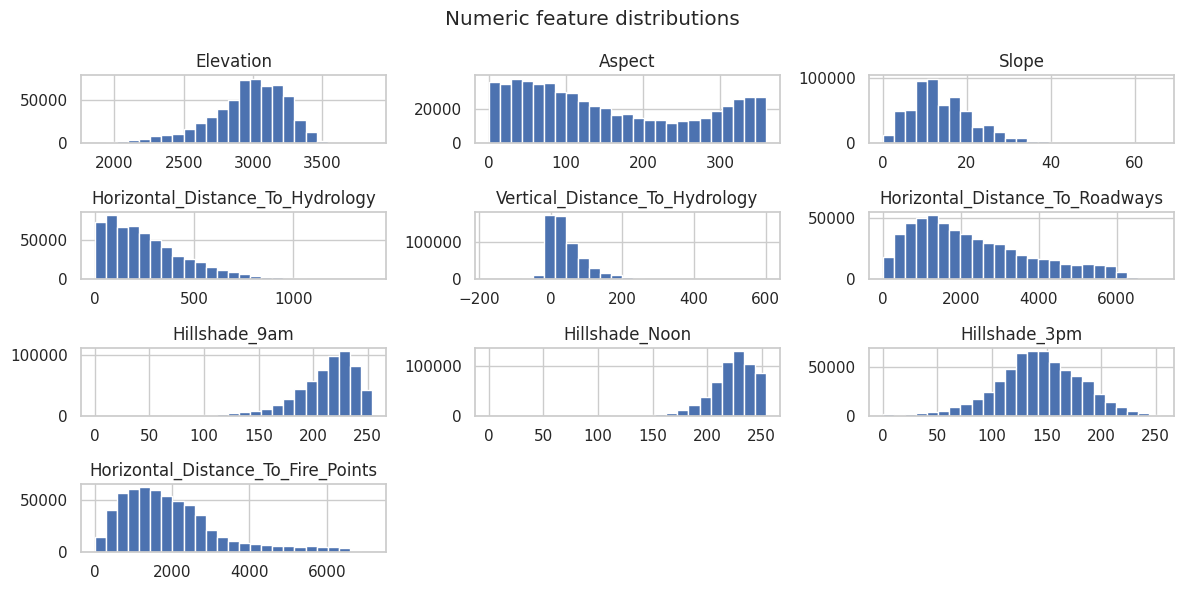

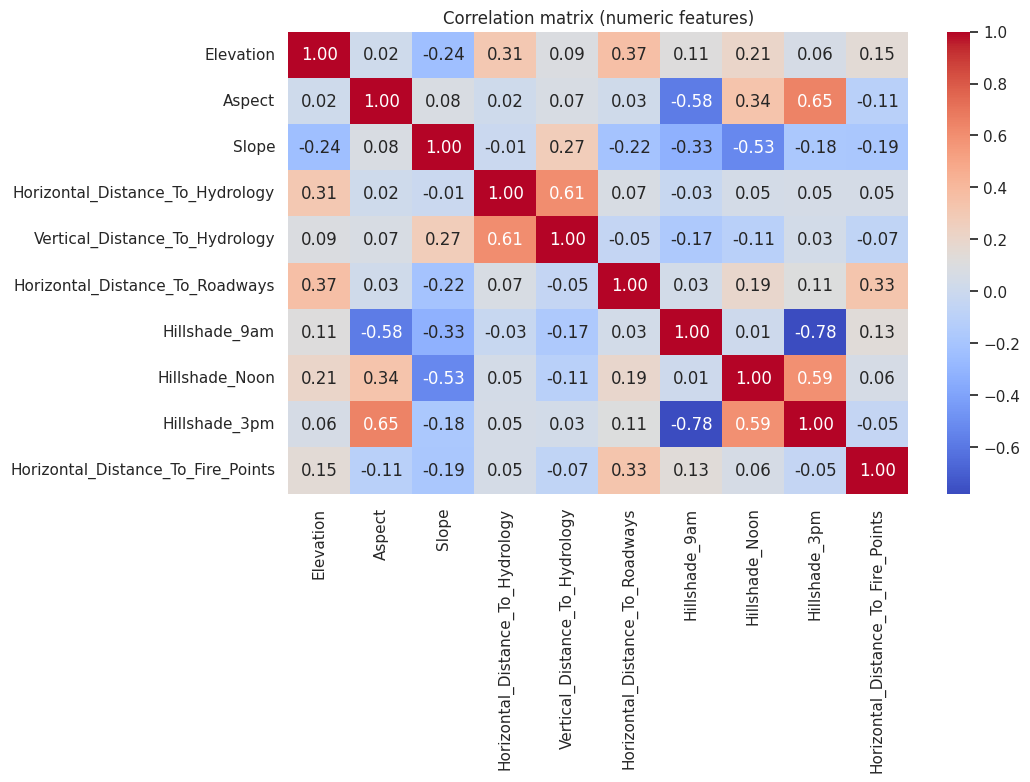

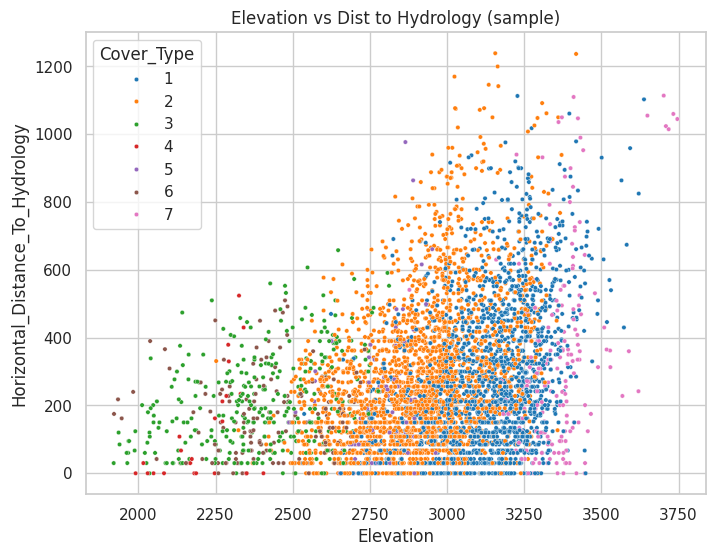

In [5]:

# 1) Class distribution bar plot
plt.figure(figsize=(8,4))
sns.countplot(x='Cover_Type', data=df, palette='crest')
plt.title("Cover Type distribution (counts)")
plt.xlabel("Cover Type (1..7)")
plt.show()

# 2) Histograms for numeric features (compact)
df[NUMERIC_COLS].hist(bins=25, figsize=(12,6))
plt.suptitle("Numeric feature distributions")
plt.tight_layout()
plt.show()

# 3) Correlation heatmap (numeric only)
plt.figure(figsize=(10,6))
sns.heatmap(df[NUMERIC_COLS].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation matrix (numeric features)")
plt.show()

# 4) Scatter plot: Elevation vs Horizontal_Distance_To_Hydrology colored by class (sample for clarity)
sample_scatter = df.sample(n=5000, random_state=RND) if len(df)>5000 else df
plt.figure(figsize=(8,6))
sns.scatterplot(x='Elevation', y='Horizontal_Distance_To_Hydrology', hue='Cover_Type', palette='tab10', data=sample_scatter, s=10, legend='brief')
plt.title("Elevation vs Dist to Hydrology (sample)")
plt.show()


# Step 5 — Preprocessing: split and optional scaling

In [6]:

# Features and target
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

# Stratified train-test split to keep class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RND)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# (Optional) Scale numeric columns if you're using non-tree models
scale_numeric = False   # set True only if you will use e.g., LogisticRegression, SVM, or KNN
if scale_numeric:
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train[NUMERIC_COLS])
    X_test_num = scaler.transform(X_test[NUMERIC_COLS])
    # replace numeric cols with scaled arrays
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[NUMERIC_COLS] = X_train_num
    X_test_scaled[NUMERIC_COLS] = X_test_num
    X_train, X_test = X_train_scaled, X_test_scaled
    print("Numeric features scaled.")


Train shape: (464809, 54) Test shape: (116203, 54)


# Step 6 — Baseline training (Random Forest & XGBoost)

In [7]:
from time import time
print("Training baseline models... (these take time)")

# Random Forest baseline
rf = RandomForestClassifier(n_estimators=200, random_state=RND, n_jobs=-1)
t0 = time(); rf.fit(X_train, y_train); t_rf = time() - t0
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf); f1_rf = f1_score(y_test, y_pred_rf, average='macro')
print(f"RF baseline: time {t_rf:.1f}s, accuracy {acc_rf:.4f}, f1_macro {f1_rf:.4f}")

# XGBoost baseline
# Adjust target variable for XGBoost to be zero-indexed
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

xgb = XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='mlogloss', random_state=RND, n_jobs=-1)
t0 = time(); xgb.fit(X_train, y_train_xgb); t_xgb = time() - t0
y_pred_xgb = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test_xgb, y_pred_xgb); f1_xgb = f1_score(y_test_xgb, y_pred_xgb, average='macro')
print(f"XGB baseline: time {t_xgb:.1f}s, accuracy {acc_xgb:.4f}, f1_macro {f1_xgb:.4f}")

Training baseline models... (these take time)
RF baseline: time 312.6s, accuracy 0.9542, f1_macro 0.9247
XGB baseline: time 124.3s, accuracy 0.9081, f1_macro 0.9002


# Step 7 — Evaluate: classification report & confusion matrix

RandomForest classification report:
              precision    recall  f1-score   support

           1     0.9644    0.9423    0.9532     42368
           2     0.9492    0.9736    0.9612     56661
           3     0.9386    0.9599    0.9491      7151
           4     0.9155    0.8488    0.8809       549
           5     0.9535    0.7778    0.8567      1899
           6     0.9315    0.8926    0.9116      3473
           7     0.9739    0.9471    0.9603      4102

    accuracy                         0.9542    116203
   macro avg     0.9467    0.9060    0.9247    116203
weighted avg     0.9543    0.9542    0.9540    116203



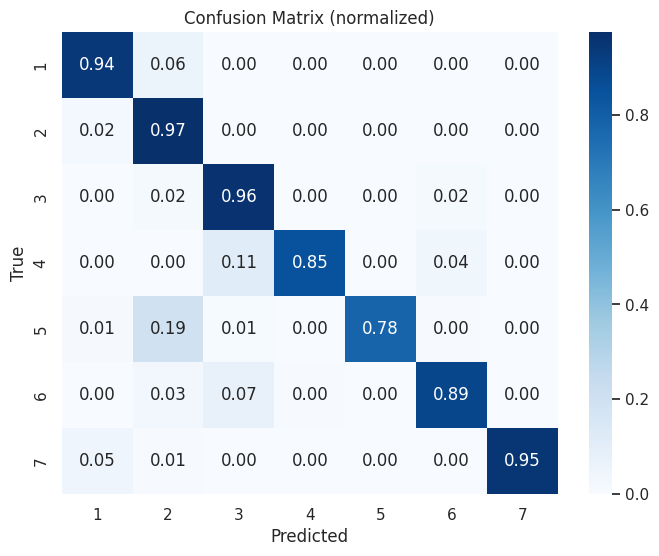

XGBoost classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0847    0.1165    0.0981     42368
           2     0.0208    0.0027    0.0047     56661
           3     0.0602    0.0045    0.0083      7151
           4     0.0000    0.0000    0.0000       549
           5     0.0027    0.0047    0.0034      1899
           6     0.0000    0.0000    0.0000      3473
           7     0.0000    0.0000    0.0000      4102

    accuracy                         0.0441    116203
   macro avg     0.0210    0.0161    0.0143    116203
weighted avg     0.0448    0.0441    0.0387    116203



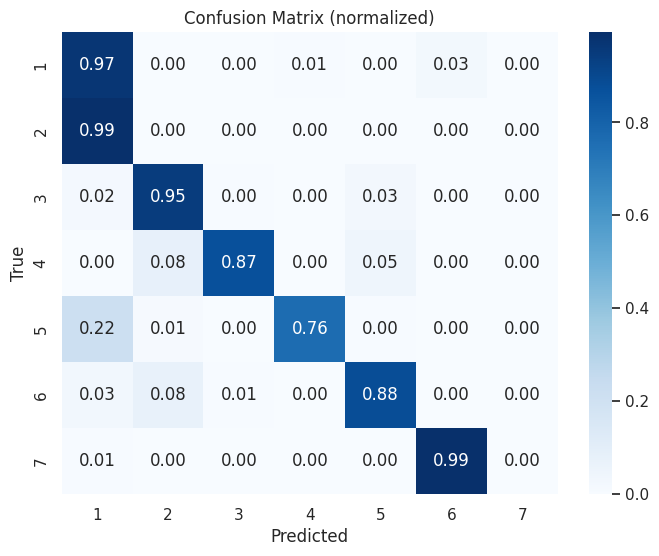

In [8]:

def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = ".2f"
    else:
        fmt = "d"
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix' + (' (normalized)' if normalize else ' (counts)'))
    plt.show()

classes = sorted(y.unique())

print("RandomForest classification report:")

print(classification_report(y_test, y_pred_rf, digits=4))
plot_confusion_matrix(y_test, y_pred_rf, classes, normalize=True)

print("XGBoost classification report:")
print(classification_report(y_test, y_pred_xgb, digits=4))
plot_confusion_matrix(y_test, y_pred_xgb, classes, normalize=True)


# Step 8 — Feature importance (RF & XGB) + permutation importance

RandomForest top features:


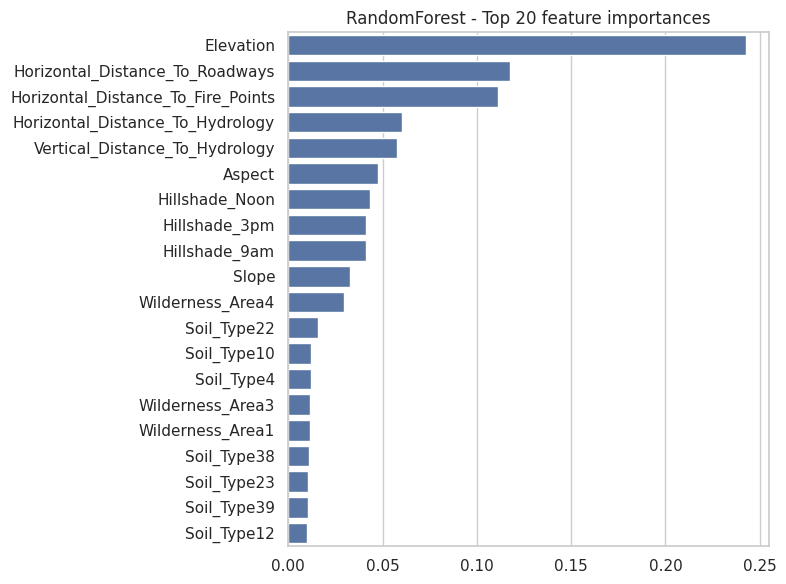

XGBoost top features:


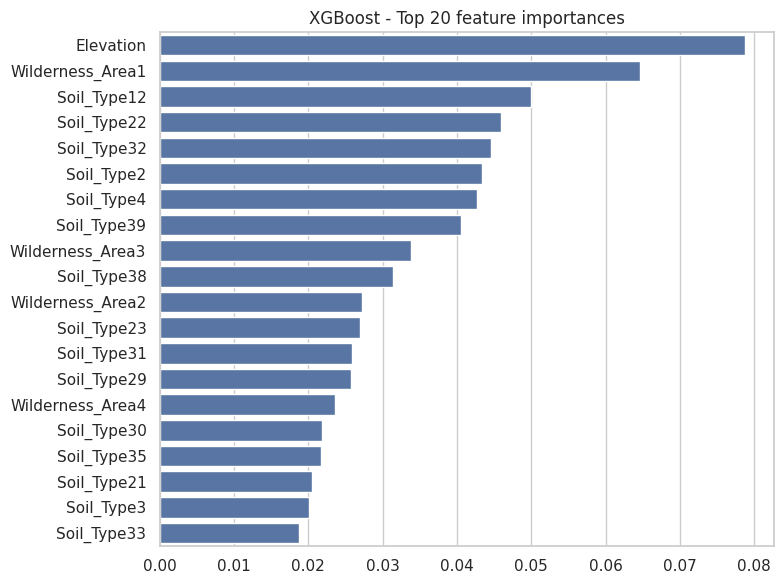

In [9]:
# Feature importance plotting function
def plot_feat_importances(importances, feat_names, title="Feature importances (top 20)"):
    idx = np.argsort(importances)[-20:][::-1]
    plt.figure(figsize=(8, 6))
    sns.barplot(x=importances[idx], y=np.array(feat_names)[idx])
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Get feature names
feat_names = X.columns.tolist()

# RandomForest feature importances
print("RandomForest top features:")
plot_feat_importances(rf.feature_importances_, feat_names, title="RandomForest - Top 20 feature importances")

# XGBoost feature importances
print("XGBoost top features:")
plot_feat_importances(xgb.feature_importances_, feat_names, title="XGBoost - Top 20 feature importances")


# Step 9 — Optional: Hyperparameter tuning (RandomizedSearchCV)

In [11]:
from sklearn.model_selection import RandomizedSearchCV

TUNE_ON_SUBSAMPLE = True
SUBSAMPLE_SIZE = 100000   # set lower if you have less CPU/memory
N_ITER = 20               # number of random parameter settings to try (increase for thorough search)
CV = 3

if TUNE_ON_SUBSAMPLE:
    X_tune, _, y_tune, _ = train_test_split(X_train, y_train, train_size=SUBSAMPLE_SIZE, stratify=y_train, random_state=RND)
    print("Tuning on subsample:", X_tune.shape)
else:
    X_tune, y_tune = X_train, y_train

# RF parameter distribution
rf_param_dist = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5]
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=RND, n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=N_ITER, scoring='f1_macro', cv=CV, verbose=2, n_jobs=-1, random_state=RND
)

print("Starting RF RandomizedSearchCV ...")
t0 = time()
rf_search.fit(X_tune, y_tune)
print("RF tuning completed in {:.1f}s".format(time()-t0))
print("Best RF params:", rf_search.best_params_)
rf_best = rf_search.best_estimator_

# XGBoost tuning
xgb_param_dist = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Adjust target variable for XGBoost to be zero-indexed
y_tune_xgb = y_tune - 1

xgb_search = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RND, n_jobs=-1),
    param_distributions=xgb_param_dist,
    n_iter=N_ITER, scoring='f1_macro', cv=CV, verbose=2, n_jobs=-1, random_state=RND
)

print("Starting XGB RandomizedSearchCV ...")
t0 = time()
xgb_search.fit(X_tune, y_tune_xgb)
print("XGB tuning completed in {:.1f}s".format(time()-t0))
print("Best XGB params:", xgb_search.best_params_)
xgb_best = xgb_search.best_estimator_

Tuning on subsample: (100000, 54)
Starting RF RandomizedSearchCV ...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
RF tuning completed in 2583.9s
Best RF params: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 30}
Starting XGB RandomizedSearchCV ...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGB tuning completed in 1635.8s
Best XGB params: {'subsample': 1.0, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


#
Step 10 — Evaluate tuned models & compare

Evaluating tuned RandomForest
Evaluating tuned XGBoost


,Accuracy,F1_macro
Model,,
RandomForest,0.923677,0.875344
XGBoost,0.032417,0.011514


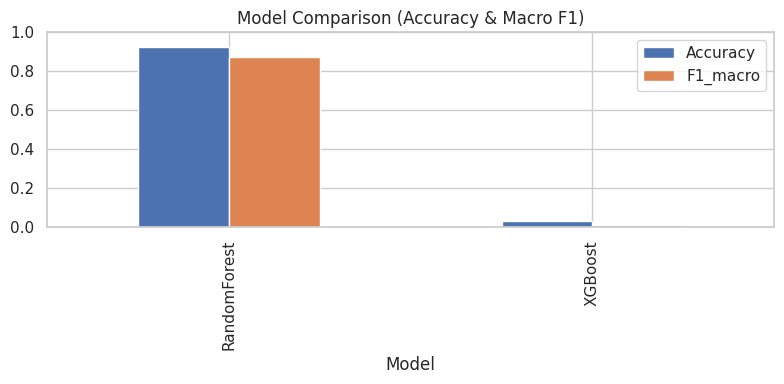

RF classification report:
              precision    recall  f1-score   support

           1     0.9383    0.9050    0.9214     42368
           2     0.9173    0.9547    0.9356     56661
           3     0.9019    0.9297    0.9156      7151
           4     0.8569    0.7741    0.8134       549
           5     0.9126    0.6435    0.7548      1899
           6     0.8870    0.8341    0.8598      3473
           7     0.9522    0.9030    0.9269      4102

    accuracy                         0.9237    116203
   macro avg     0.9094    0.8492    0.8753    116203
weighted avg     0.9239    0.9237    0.9231    116203



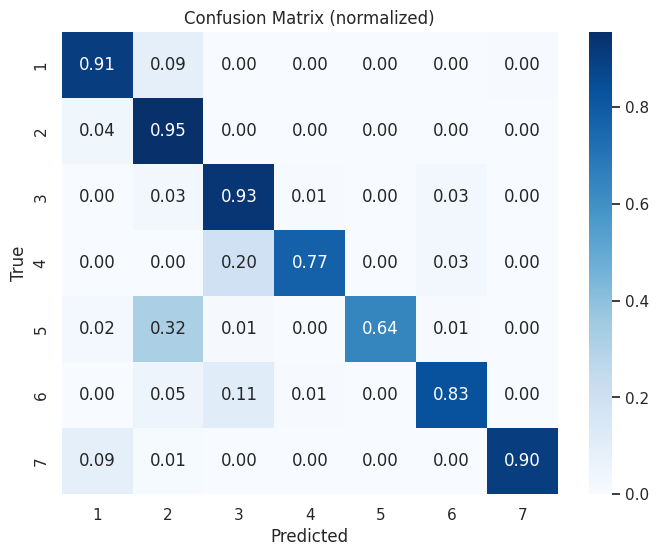

XGB classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         0
           1     0.0609    0.0839    0.0706     42368
           2     0.0210    0.0027    0.0048     56661
           3     0.1022    0.0071    0.0133      7151
           4     0.0000    0.0000    0.0000       549
           5     0.0027    0.0047    0.0034      1899
           6     0.0000    0.0000    0.0000      3473
           7     0.0000    0.0000    0.0000      4102

    accuracy                         0.0324    116203
   macro avg     0.0234    0.0123    0.0115    116203
weighted avg     0.0388    0.0324    0.0289    116203



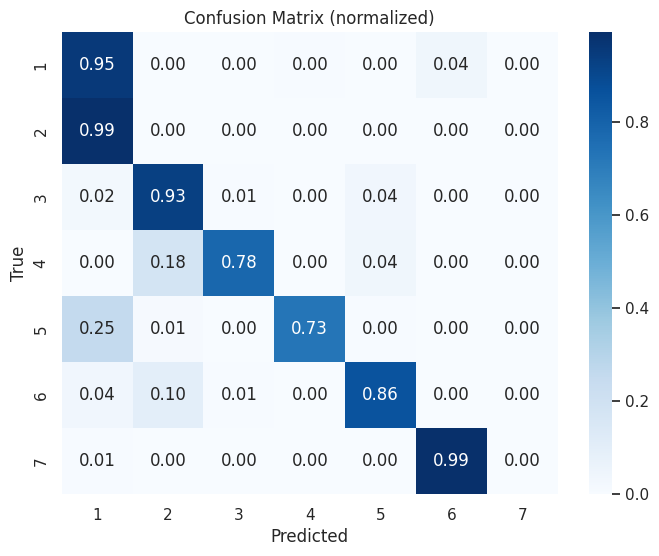

In [12]:

# If you didn't tune, rf_best/xgb_best aren't defined; fall back to baseline
try:
    rf_eval = rf_best
    print("Evaluating tuned RandomForest")
except NameError:
    rf_eval = rf
    print("Using RF baseline (no tuned model found)")

try:
    xgb_eval = xgb_best
    print("Evaluating tuned XGBoost")
except NameError:
    xgb_eval = xgb
    print("Using XGB baseline (no tuned model found)")

# Predictions
y_pred_rf_eval = rf_eval.predict(X_test)
y_pred_xgb_eval = xgb_eval.predict(X_test)

# Metrics
summary = [
    {'Model': 'RandomForest', 'Accuracy': accuracy_score(y_test, y_pred_rf_eval), 'F1_macro': f1_score(y_test, y_pred_rf_eval, average='macro')},
    {'Model': 'XGBoost', 'Accuracy': accuracy_score(y_test, y_pred_xgb_eval), 'F1_macro': f1_score(y_test, y_pred_xgb_eval, average='macro')}
]
results_df = pd.DataFrame(summary).set_index('Model')
display(results_df)

# Plot comparison
results_df.plot(kind='bar', figsize=(8,4), ylim=(0,1))
plt.title('Model Comparison (Accuracy & Macro F1)')
plt.tight_layout()
plt.show()

# Confusion matrices for tuned/baseline models
print("RF classification report:")
print(classification_report(y_test, y_pred_rf_eval, digits=4))
plot_confusion_matrix(y_test, y_pred_rf_eval, classes)

print("XGB classification report:")
print(classification_report(y_test, y_pred_xgb_eval, digits=4))
plot_confusion_matrix(y_test, y_pred_xgb_eval, classes)


# Step 11 — Save models (optional)

# Optional Step 12 — SHAP explanations (global & per-class)

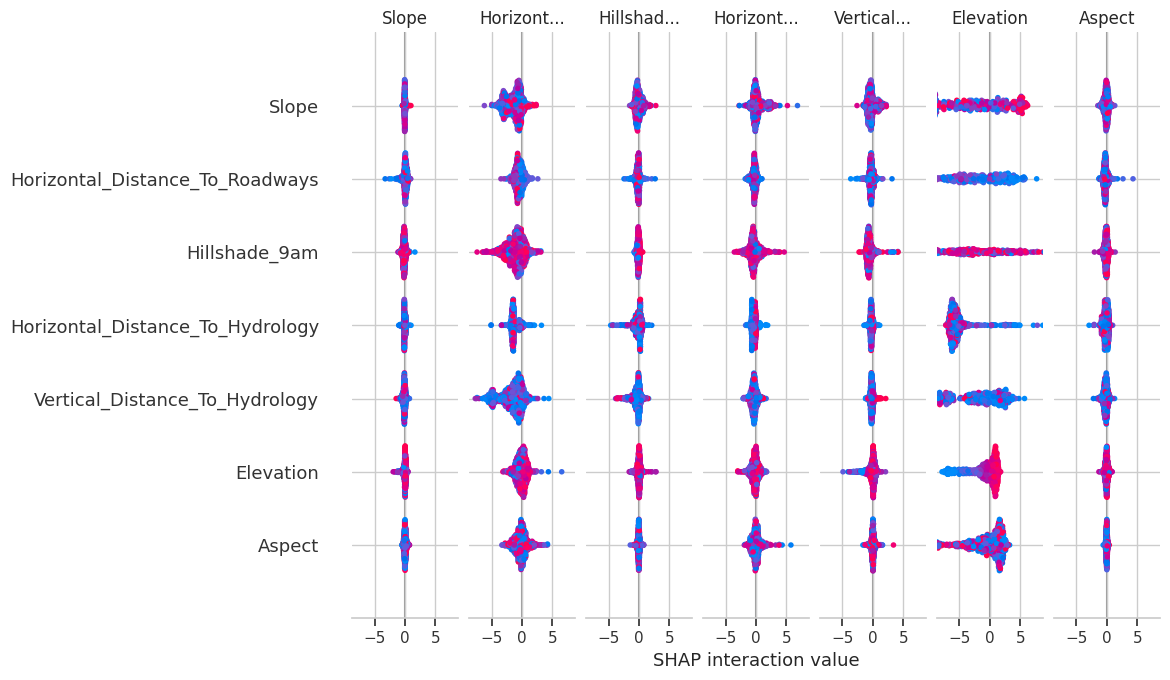

In [14]:

import shap
# Use the tree explainer for tree-based models
explainer = shap.TreeExplainer(xgb_eval)   # or rf_eval
# Sample background for speed
bg = X_train.sample(1000, random_state=RND)
shap_values = explainer.shap_values(bg)   # for multiclass XGBoost returns list; be mindful of memory

# Summary plot (global importance)
# If shap_values is list (multiclass), you can inspect one class's explanations:
if isinstance(shap_values, list):
    # show summary for class 0's shap values
    shap.summary_plot(shap_values[0], bg, feature_names=feat_names)
else:
    shap.summary_plot(shap_values, bg, feature_names=feat_names)
